In [85]:
import requests
from requests.compat import urljoin
import json
import pandas as pd
import io
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.sparse.linalg import svds
from scipy import spatial
import sklearn.preprocessing as pp
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
import time
import sys

# Data Loading
First we can load the data from the remote interface but to avoid issues with network files are already save in the folder

Instead of load them from the interface we just load them from files

In [86]:
basedata="../recommenderapp/static/data"
moviesraw=pd.read_csv("moviesraw.dat",sep='::',header=None)
moviesraw.columns=["MovieID","Movie","Genres"]
moviesraw.head()

,MovieID,Movie,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [87]:
usersraw=pd.read_csv("usersraw.dat",sep='::',header=None)
usersraw.columns=["UserID", "Gender", "Age", "Occupation", "Zip-code"]
usersraw.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [88]:
ratingsraw=pd.read_csv("ratingsraw.dat",sep='::',header=None)
ratingsraw.columns=["UserID", "MovieID", "Rating", "Timestamp"]
ratingsraw.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# Data transformation
The first step manipulating the movies data to extract year, title and break down the category data. This step is also used to extract and format the location of the image files.

In [89]:
movies=moviesraw
movies.Movie=movies.Movie.str.replace(r"\(.*\) ?\(","(")
movies[["Text","Year"]]=moviesraw.Movie.str.split(r" \(",expand=True,n=1)
movies.Year=movies.Year.str.replace(")","").astype(int)
movies.Text=movies.Text.str.replace(r"[^a-zA-Z ]","")
movies['Filename']="images/movies/"+movies.MovieID.astype(str)+".jpg"
movies[["Cat1","Cat2","Cat3","Cat4","Cat5","Cat6"]]=movies.Genres.str.split(r"|",expand=True,n=5)
movies.head()

,MovieID,Movie,Genres,Text,Year,Filename,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,images/movies/1.jpg,Animation,Children's,Comedy,None,None,None
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,images/movies/2.jpg,Adventure,Children's,Fantasy,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,images/movies/3.jpg,Comedy,Romance,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale,1995,images/movies/4.jpg,Comedy,Drama,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,images/movies/5.jpg,Comedy,None,None,None,None,None


I need to correct the title for the movies that have a "The" appended to the end 

In [90]:
fixname=movies.Text.str.extractall(r'(?P<base>^[\w ]*)(?P<space>[\s])(?P<the>The$)')
fixname['final']=fixname.the+fixname.space+fixname.base
fixname=fixname.reset_index()
fixname=fixname[['level_0','final']]
fixname=fixname.rename(columns={'level_0': 'MovieID', 'final': 'Title'})
fixname=fixname.set_index("MovieID")
movies=movies.join(fixname)
movies.Title=movies['Title'].fillna(movies['Text'])
movies.head()

,MovieID,Movie,Genres,Text,Year,Filename,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Title
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,images/movies/1.jpg,Animation,Children's,Comedy,None,None,None,Toy Story
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,images/movies/2.jpg,Adventure,Children's,Fantasy,None,None,None,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,images/movies/3.jpg,Comedy,Romance,None,None,None,None,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale,1995,images/movies/4.jpg,Comedy,Drama,None,None,None,None,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,images/movies/5.jpg,Comedy,None,None,None,None,None,Father of the Bride Part II


This steps creates a unique list of Categories

In [91]:
cat_cols = [col for col in movies.columns if 'Cat' in col]
categories= pd.DataFrame(columns=['MovieID','Category'])
for cat_col in cat_cols:
    catadd=movies.dropna(subset=[cat_col])[["MovieID",cat_col]]
    catadd.columns=["MovieID",'Category']
    categories=categories.append(catadd, ignore_index=True)
ucat=categories.Category.unique()
ucat.sort()
ucategories=pd.DataFrame(data=ucat,columns=['Category'])
ucategories

,Category
0,Action
1,Adventure
2,Animation
3,Children's
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Fantasy
9,Film-Noir


The movie Matrix is produce

In [92]:
movies=movies.reset_index()
movies=movies[['MovieID','Movie','Title','Year','Filename']]
movies.head()

,MovieID,Movie,Title,Year,Filename
0,1,Toy Story (1995),Toy Story,1995,images/movies/1.jpg
1,2,Jumanji (1995),Jumanji,1995,images/movies/2.jpg
2,3,Grumpier Old Men (1995),Grumpier Old Men,1995,images/movies/3.jpg
3,4,Waiting to Exhale (1995),Waiting to Exhale,1995,images/movies/4.jpg
4,5,Father of the Bride Part II (1995),Father of the Bride Part II,1995,images/movies/5.jpg


Both data Matrix are save for use by the application.

In [93]:
ucategories.to_feather(os.path.join(basedata,'categories.feather'))

In [94]:
movies.to_feather(os.path.join(basedata,'movies.feather'))

# Recommendation Based on Genres - Approach 1
## Data Manipulation
Each movie can belong to multiple genres. The first step is to break down the movies into multiple generes. this steps will generate one row for movie per category.
At this point we only need to do a simple mean per movie based on ratings. I calculate the average rating per user so that ratings can ne normalized per user with the following formulate.

$$ r_a= \frac{\sum_i{r_m-\frac{\sum_i{r_u}}{n_u}}}{n_m}$$
Where
- $r_a$ is the mean user adjusted rating.
- $r_u$ are ratings per user
- $n_u$ total number of rating per user
- $r_m$ are ratings per movie
- $n_m$ total number of rating per movie

In [95]:
ratings=ratingsraw
usermean=ratings[['UserID','Rating']].groupby('UserID').mean('Rating')
usermean.columns=['MeanUserRating']
usermean.head()

,MeanUserRating
UserID,
1,4.188679
2,3.713178
3,3.901961
4,4.190476
5,3.146465


The Adjusted Rating is then calculated.

In [96]:
ratings=ratings.set_index('UserID')
ratings=ratings.join(usermean)
ratings['MeanRating']=ratings['Rating']-ratings['MeanUserRating']
ratings.head()

,MovieID,Rating,Timestamp,MeanUserRating,MeanRating
UserID,,,,,
1,1193,5,978300760,4.188679,0.811321
1,661,3,978302109,4.188679,-1.188679
1,914,3,978301968,4.188679,-1.188679
1,3408,4,978300275,4.188679,-0.188679
1,2355,5,978824291,4.188679,0.811321


The Mean rating is now calculated based on the adjusted Means per user.

In [97]:
ratingmean=ratings[['MovieID','MeanRating']].groupby('MovieID').mean('MeanRating')
ratingmean.head()

,MeanRating
MovieID,
1,0.479497
2,-0.324143
3,-0.440247
4,-0.698816
5,-0.419777


The ratings and the average per category are join into a single table.

In [98]:
categories=categories.set_index('MovieID')
categoriesrating=categories.join(ratingmean)
categoriesrating.head()

,Category,MeanRating
MovieID,,
1,Animation,0.479497
1,Children's,0.479497
1,Comedy,0.479497
2,Adventure,-0.324143
2,Children's,-0.324143


We can see that there is one outliner with a mean rating of more than 3. This is becuase there is only one rating of that move as we can see below.

0.5581255342140179


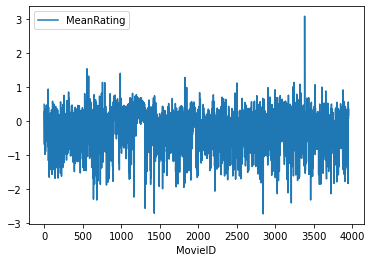

In [99]:
ratingmean=ratingmean.reset_index()
ratingmean.plot(x='MovieID',y=['MeanRating'])
ratingmean=ratingmean.set_index('MovieID')
print(ratingmean.MeanRating.std())

In [100]:
categoriesrating.loc[categoriesrating.MeanRating>2.9]

,Category,MeanRating
MovieID,,
3382,Drama,3.072727


Only one rating for "Guess Whos Coming to Dinner"


In [101]:
print(movies.loc[3382].Title)
ratings[ratings.MovieID==3382]

Guess Whos Coming to Dinner


,MovieID,Rating,Timestamp,MeanUserRating,MeanRating
UserID,,,,,
5334,3382,5,960796159,1.927273,3.072727


The above table is pivoted to get a full sparse matrix

In [102]:
catmatrix=categoriesrating.pivot(columns='Category',values='MeanRating')
catmatrix.head()

Category,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,NaN,NaN,0.479497,0.479497,0.479497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-0.324143,NaN,-0.324143,NaN,NaN,NaN,NaN,-0.324143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,-0.440247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.440247,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-0.698816,NaN,NaN,-0.698816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,-0.419777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Selection 
In order to get the top n movies per genre at this point it just a selection of the sorted values of the column corresponding to the selected genre.

In [103]:
Category='Sci-Fi'
topn=10
topnmovies=catmatrix[Category].sort_values(ascending=False)[:topn].to_frame()
movies=movies.set_index('MovieID')
topnmovies=topnmovies.join(movies)
topnmovies[['Title','Year',Category]]

,Title,Year,Sci-Fi
MovieID,,,
260,Star Wars Episode IV A New Hope,1977,0.745487
750,Dr Strangelove or How I Learned to Stop Worryi...,1963,0.741026
2571,The Matrix,1999,0.658832
1196,Star Wars Episode V The Empire Strikes Back,1980,0.592443
541,Blade Runner,1982,0.582136
1253,The Day the Earth Stood Still,1951,0.513580
741,Ghost in the Shell,1995,0.496135
1240,The Terminator,1984,0.473873
1214,Alien,1979,0.466961


## Save Data
Save the sparse matrix for use in the application

In [104]:
catmatrix=catmatrix.reset_index()

In [105]:
catmatrix.to_feather(os.path.join(basedata,'genresmatrix.feather'))

# Recommendation Based on Genres - Approach 2
## Data Manipulation
For this method we take the average ratings adjusted per user from the previous approach but this time the process uses the amount of ratings received by each movie to calculate the final rating.

$$ r_a= \frac{\sum_i{r_m-\frac{\sum_i{r_u}}{n_u}}}{n_m}$$
Where
- $r_a$ is the mean user adjusted rating.
- $r_u$ are ratings per user
- $n_u$ total number of rating per user
- $r_m$ are ratings per movie
- $n_m$ total number of rating per movie


$$r_t=r_a(1-\frac{1}{\sqrt(1+{n_r}^2)})$$

Where
- $r_t$ is the thrend adjusted rating.
- $r_a$ is the mean user adjusted rating.
- $n_r$ is the number of rating per movie.

The next step is to calculate the adjusted value based on the above formula.

In [106]:
ratingsnumber=ratings.reset_index()
ratingsnumber=ratingsnumber[['MovieID','UserID']].groupby('MovieID').nunique()
ratingsnumber.columns=["Counts"]
ratingsnumber['AdjustedFactor']=1-1/(1*np.sqrt(1+ratingsnumber.Counts*ratingsnumber.Counts))
ratingsnumber.head()

,Counts,AdjustedFactor
MovieID,,
1,2077,0.999519
2,701,0.998573
3,478,0.997908
4,170,0.994118
5,296,0.996622


The 2 datasets are join into a single dataset.

In [107]:
categoriesrating=categoriesrating.join(ratingsnumber)
categoriesrating.head()

,Category,MeanRating,Counts,AdjustedFactor
MovieID,,,,
1,Animation,0.479497,2077.0,0.999519
1,Children's,0.479497,2077.0,0.999519
1,Comedy,0.479497,2077.0,0.999519
2,Adventure,-0.324143,701.0,0.998573
2,Children's,-0.324143,701.0,0.998573


In [108]:
categoriesrating['AdjMeanRating']=categoriesrating.MeanRating*categoriesrating.AdjustedFactor
categoriesrating.head()

,Category,MeanRating,Counts,AdjustedFactor,AdjMeanRating
MovieID,,,,,
1,Animation,0.479497,2077.0,0.999519,0.479266
1,Children's,0.479497,2077.0,0.999519,0.479266
1,Comedy,0.479497,2077.0,0.999519,0.479266
2,Adventure,-0.324143,701.0,0.998573,-0.323680
2,Children's,-0.324143,701.0,0.998573,-0.323680


We can then plot like before the results. The plot show that there are no longer movies that have significants spikes due to high single or low number of ratings.


0.500696977709134


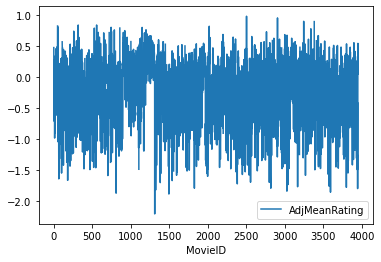

In [109]:
catplot=categoriesrating.reset_index()
catplot=catplot[['MovieID','AdjMeanRating']].groupby('MovieID').mean()
catplot=catplot.reset_index()
catplot.plot(x='MovieID',y=['AdjMeanRating'])
print(catplot.AdjMeanRating.std())

In [110]:
catmatrix2=categoriesrating.pivot(columns='Category',values='AdjMeanRating')
catmatrix2.head()

Category,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,NaN,NaN,0.479266,0.479266,0.479266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-0.32368,NaN,-0.323680,NaN,NaN,NaN,NaN,-0.32368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,-0.439326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.439326,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-0.694705,NaN,NaN,-0.694705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,-0.418358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Selection
Doing the same selection as above

In [111]:
Category='Sci-Fi'
topn=10
topnmovies=catmatrix2[Category].sort_values(ascending=False)[:topn].to_frame()
topnmovies=topnmovies.join(movies)
topnmovies[['Title','Year',Category]]

,Title,Year,Sci-Fi
MovieID,,,
260,Star Wars Episode IV A New Hope,1977,0.745237
750,Dr Strangelove or How I Learned to Stop Worryi...,1963,0.740484
2571,The Matrix,1999,0.658578
1196,Star Wars Episode V The Empire Strikes Back,1980,0.592245
541,Blade Runner,1982,0.581813
1253,The Day the Earth Stood Still,1951,0.512661
741,Ghost in the Shell,1995,0.494555
1240,The Terminator,1984,0.473647
1214,Alien,1979,0.466730


## Save Data
Save the sparse matrix for use in the application

In [112]:
catmatrix2=catmatrix.reset_index()
catmatrix2.to_feather(os.path.join(basedata,'genresmatrix2.feather'))

# Collaborative Recommendation System
## User Based
##  Model Explanation
The followign steps are going to prepare the data in a similar way for both recommendations systems.
I am going to use a user werigthed average for the ratings before they are applied to any future process.

This process is going to explore how to do the recommendation system using a User based approach. The data has been prepared ahead time.

The process is doing a Pearson Correlation. This means before calculating the Similarity value the rating is adjusted according with the mean of the users rating.

The formula is defined as


$$ r_{xi} = \frac{\sum_{j{\in}N}s_{xy}\cdot(r_{yi})}{\sum_{j{\in}N}|s{xy}|} $$
Where
- $r_{xi}$ is the mean movie adjusted rating.

- $s_{ij}$ is the similarity distance using cosine similarity

- $r_{xj}$ rate of user X of movie j

- $b{xj}$ average rating of user x for movie j


The UBCF uses the relationships between users to calculate similarity. In this users rating information is used to calculate a similary matrix with the above formula that allows to find similar items.


I will be using RMSE to evaluate the overal performace of this model.


### Data Preparation
This steps onle pivots the data to have a ful utility matrix. All operation are done using Numpy matrices operations so the data is also converted to a numpy array.

The first step is to transform the data by using a Pivot operation to get a full utility matrix.

In [113]:
ratings_movies = ratingsraw.pivot(index = 'UserID', columns ='MovieID', values = 'Rating')
ratings_movies=ratings_movies
utilityMatrix=ratings_movies.to_numpy(np.float16)
ratings_movies

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Functions.
Here are the functions that will be use later to computer the similary matrix and the user distance.

The first function calculates the similarity matrix given a dataframe with data.

In [114]:
def getSimilarityMatrix(utilityDataFrame):
    # Calculates the mean for each row
    rowMean=utilityDataFrame.mean(1,True).to_numpy(np.float16)
    # Convers  the array to a matrix
    matrixRowMean=rowMean.reshape(-1,1)
    # Data Frame is converted into matrix sparce matrix
    utilityMatrix=utilityDataFrame.to_numpy(np.float16)
    utilityMatrixSparse = scipy.sparse.csc_matrix(utilityMatrix)
    # Each non Nan are substract the mean of the row.
    utilityMatrixCenter=utilityMatrixSparse-matrixRowMean
    # All Nan alements are converted to zero
    utilityMatrixCenterZero=np.nan_to_num(utilityMatrixCenter)
    # Cosine similarity matrix is calculated
    SimilarityMatrix = cosine_similarity(utilityMatrixCenterZero)
    return SimilarityMatrix

Randoming assings block of matrix for model verification

In [115]:
def getTestTrainSplit(utilityMatrix,xsplit, ysplit):
    xl,yl=utilityMatrix.shape
    xts=xsplit
    yts=ysplit
    xs=np.random.randint(xl-xts)
    ys=np.random.randint(yl-yts)
    test=utilityMatrix[xs:xs+xts,ys:ys+yts].copy()
    train=utilityMatrix.copy()
    train[xs:xs+xts,ys:ys+yts]=np.nan
    return test,train,xs,xts,ys,yts

Calculates the Rating using User to User UBCF

In [116]:
def getRatingUBCF(utilityMatrix,similarityMatrix,rowid,colid,k,globalave,debug=False):
    row=similarityMatrix[rowid]
    aveuser=np.nanmean(utilityMatrix[:,colid])
    #col=utilityMatrix[:,colid]
    col=utilityMatrix[:,colid]-aveuser
    mask=~np.isnan(col)
    if debug:
        print("mask=",mask)
        print ("row=",row)
        print(col)
        #print ("colave",col-aveuser)
    simrow=np.multiply(row,col)
    #simrow=np.multiply(row,col)
    simcol=np.multiply(row,mask)
    simcol[rowid]=np.nan
    if debug:
        print("simrow",simrow)
        print("simcol",simcol)
    validrow=simrow[mask]
    validcol=simcol[mask]
    if debug:    
        print("validrow",validrow)
    sortedvalues=np.argsort(validrow)
    if debug:
        print("sorted values",sortedvalues)
    topn=sortedvalues[-k:]
    result=np.sum(validrow[topn])/np.sum(np.abs(validcol[topn]))+aveuser
    #result=np.sum(validrow[topn])/np.sum(np.abs(validcol[topn]))
    if np.isnan(result):
        if np.isnan(aveuser):
            result=globalave
        else:
            result=aveuser
    if debug:
        print("aveuser",aveuser)
        print("topn",topn)
        print("validcol",validcol[k])
        print("validrow",validrow[[k]])
        print("arriba",np.nansum(validrow[k]))
        print("abajo",np.sum(np.abs(validcol[k])))
        print("result=",result)        
    return(result)

Calculates the missing ratings for entire matrix using UBCF

In [117]:
def getFullRatingsUBCF(utilityMatrix,similarityMatrix):    
    final=np.copy(utilityMatrix)
    v,h = utilityMatrix.shape
    for i in range(v):
        for j in range(h):
            if np.isnan(utilityMatrix[i,j]):
                    final[i,j]=getRatingUBCF(utilityMatrix,similarityMatrix,i,j,2)
        if (i%100==0):
            print("%s of total %s"%(i,v))
    return final

Calculates rmse for model UBCF

In [118]:
def getRmseUBCF(actualData,train,xs,xts,ys,yts,k):    
    sums=0
    n=0
    similarityMatrix=getSimilarityMatrix(pd.DataFrame(train))   
    globalave=np.nanmean(actualData)
    for i in range(xs,xs+xts):
        for j in range(ys,ys+yts):
            if not np.isnan(actualData[i,j]):
                result=getRatingUBCF(train,similarityMatrix,i,j,k,globalave,False)
                if np.isnan(result):
                    print("------------Nan",i,j)
                    result=getRatingUBCF(train,similarityMatrix,i,j,k,globalave,True)
                    
                sums=sums+(result-actualData[i,j])**2
                n=n+1
    rmse=np.sqrt(sums/n)
    return rmse

### Evaluation
The first step in the evalution process is to find the correct value for the k neighbors. This steps does a loop across to find a optimal k value.

In [119]:
test,train,xs,xts,ys,yts=getTestTrainSplit(utilityMatrix,200,100)

mink=2
topk=400
i=0
step=10
rmsek=np.zeros(len(range(mink,topk,step)))
timek=np.zeros(len(range(mink,topk,step)))
for k in range(mink,topk,step):
    start_time = time.time()
    rmsek[i]=getRmseUBCF(utilityMatrix,train,xs,xts,ys,yts,k)
    timek[i]=(time.time() - start_time)
    i+=1 

[Text(0.5, 0, 'K Value'), Text(0, 0.5, 'Time')]

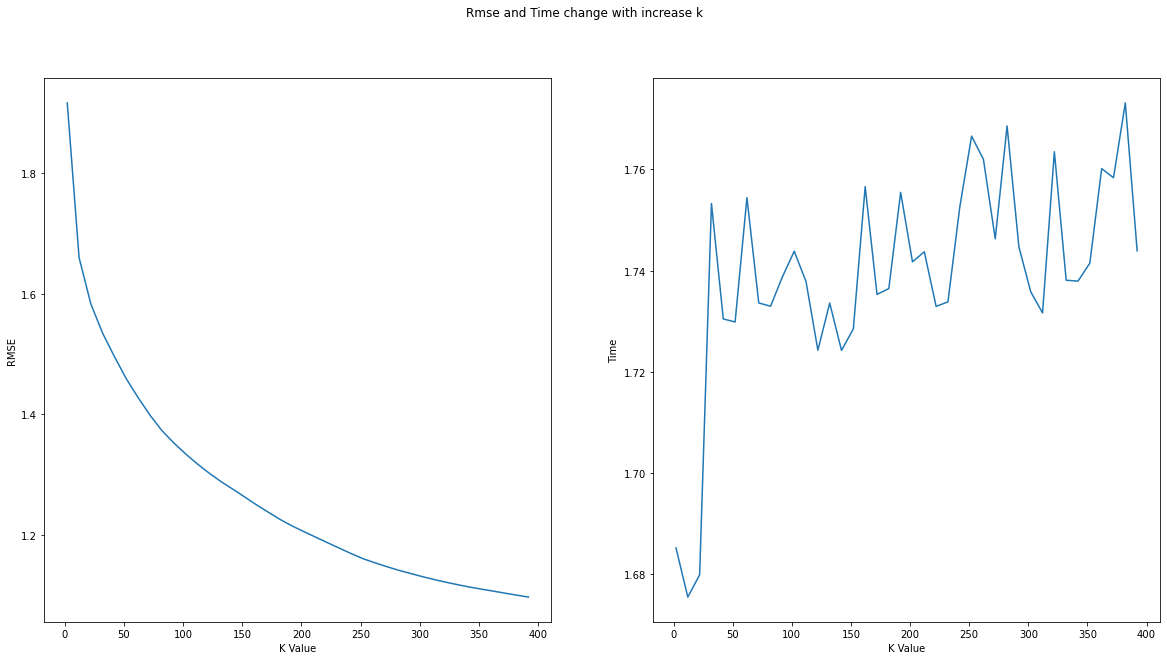

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Rmse and Time change with increase k')
ax1.plot(range(mink,topk,step),rmsek)
ax2.plot(range(mink,topk,step),timek)
ax1.set(xlabel='K Value', ylabel='RMSE')
ax2.set(xlabel='K Value', ylabel='Time')

### Iterations

Here I run a total of 10 of test train splits to evaluate the accuracy of the model. We can see that there is no significant difference between the different iterations. A k=10 was used

In [121]:
k=10
numbercycles=10
rmsec=np.zeros(numbercycles)
timec=np.zeros(numbercycles)
for i in range(numbercycles):
    test,train,xs,xts,ys,yts=getTestTrainSplit(utilityMatrix,200,100)
    start_time = time.time()
    rmsec[i]=getRmseUBCF(utilityMatrix,train,xs,xts,ys,yts,k)
    timec[i]=(time.time() - start_time)     
rmsec    

array([1.76118822, 1.63795669, 1.39533214, 1.56300262, 1.643597  ,
       1.65934004, 1.66303808, 1.71409737, 1.60568516, 1.59049128])

[Text(0.5, 0, 'Cycle'), Text(0, 0.5, 'Time')]

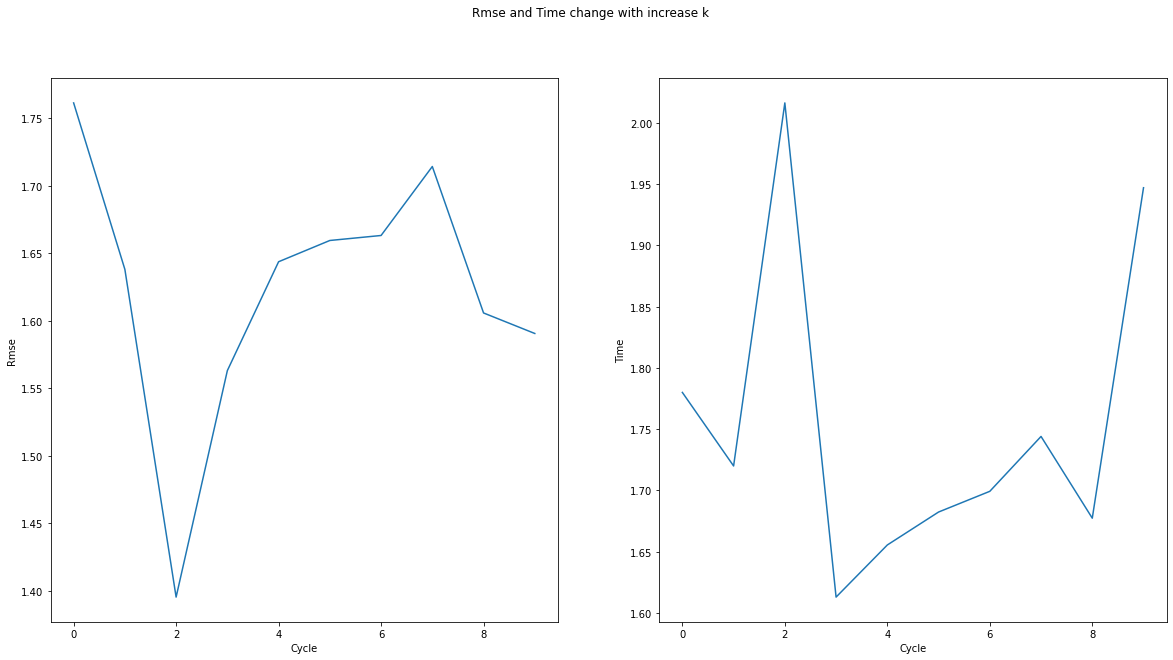

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Rmse and Time change with increase k')
ax1.plot(range(numbercycles),rmsec)
ax2.plot(range(numbercycles),timec)
ax1.set(xlabel='Cycle', ylabel='Rmse')
ax2.set(xlabel='Cycle', ylabel='Time')

### Predictions
Below is the code to calculate predictions out of this model


In [123]:
def getUserQueryVector(userQuery,mapiddict,size):
    result=np.full(size,np.nan)
    for i in userQuery:
        result[mapiddict[i]]=userQuery[i]
    return result

def getMapIdDictCols(df):
    mapiddict={}
    j=0
    for i in df.columns:
        mapiddict[i]=j
        j+=1
    return mapiddict,df.shape[1]

def getMapIdDictRows(df):
    mapiddict={}
    j=0
    for i in df.index:
        mapiddict[i]=j
        j+=1
    return mapiddict,df.shape[0]


def getUserPredictions(utilityMatrix,queryVector,size,k,globalave):    
   
    if utilityMatrix.shape[0] == size+1:
        utilityMatrix[size]=queryVector
    else:
        utilityMatrix=np.append(utilityMatrix,queryVector.reshape(1,-1),axis=0)

    similarityMatrix=getSimilarityMatrix(pd.DataFrame(utilityMatrix))   

    for i in range(len(queryVector)):        
        if np.isnan(queryVector[i]):
            #if i==49:
            #    queryVector[i]=getRatingUBCF(utilityMatrix,similarityMatrix,size+1,i,k,globalave,debug=True)
            #else:
                r=getRatingUBCF(utilityMatrix,similarityMatrix,size+1,i,k,globalave,debug=False)
                #if r >6:
                #    print("WArningnnn",i,r)
                queryVector[i]=r
    return queryVector


Here I simulate some inputs from users to see what the response would be. To produce good results the model needs to get more data from the users to predict more accurately.

In [124]:
topn=10
k=3
userQuery={2571:5,
           541:5,
          1214:4,
          1200:4,      
          2999:1,
          3607:1,
          3233:1,
          3323:1   
          }
globalave=np.nanmean(ratings_movies)
mapiddict,size=getMapIdDictCols(ratings_movies)
queryVector=getUserQueryVector(userQuery,mapiddict,size)
queryVector=getUserPredictions(utilityMatrix,queryVector,size,k,globalave)
queryindex=np.argsort(queryVector)
topmovies=queryindex[-topn:]
movies.iloc[topmovies]

,Movie,Title,Year,Filename
MovieID,,,,
350,"Client, The (1994)",The Client,1994,images/movies/350.jpg
290,Once Were Warriors (1994),Once Were Warriors,1994,images/movies/290.jpg
2626,Edge of Seventeen (1998),Edge of Seventeen,1998,images/movies/2626.jpg
2854,Don't Look in the Basement! (1973),Dont Look in the Basement,1973,images/movies/2854.jpg
517,Rising Sun (1993),Rising Sun,1993,images/movies/517.jpg
1214,Alien (1979),Alien,1979,images/movies/1214.jpg
1145,Snowriders (1996),Snowriders,1996,images/movies/1145.jpg
1134,Johnny 100 Pesos (1993),Johnny Pesos,1993,images/movies/1134.jpg
2720,Inspector Gadget (1999),Inspector Gadget,1999,images/movies/2720.jpg


In [125]:
topn=10
k=3
userQuery={1:5,3:1           
          }
globalave=np.nanmean(ratings_movies)
mapiddict,size=getMapIdDictCols(ratings_movies)
queryVector=getUserQueryVector(userQuery,mapiddict,size)
queryVector=getUserPredictions(utilityMatrix,queryVector,size,k,globalave)
queryindex=np.argsort(queryVector)
topmovies=queryindex[-topn:]
movies.iloc[topmovies]

,Movie,Title,Year,Filename
MovieID,,,,
350,"Client, The (1994)",The Client,1994,images/movies/350.jpg
290,Once Were Warriors (1994),Once Were Warriors,1994,images/movies/290.jpg
2626,Edge of Seventeen (1998),Edge of Seventeen,1998,images/movies/2626.jpg
2854,Don't Look in the Basement! (1973),Dont Look in the Basement,1973,images/movies/2854.jpg
517,Rising Sun (1993),Rising Sun,1993,images/movies/517.jpg
1214,Alien (1979),Alien,1979,images/movies/1214.jpg
1145,Snowriders (1996),Snowriders,1996,images/movies/1145.jpg
1134,Johnny 100 Pesos (1993),Johnny Pesos,1993,images/movies/1134.jpg
2720,Inspector Gadget (1999),Inspector Gadget,1999,images/movies/2720.jpg


## Item Based
### Model explanation.
The followign steps are going to prepare the data in a similar way for both recommendations systems.
I am going to use a user werigthed average for the ratings before they are applied to any future process.

This process is going to explore how to do the recommendation system using a User based approach. The data has been prepared ahead time.

The process is doing a Pearson Correlation. This means before calculating the Similarity value the rating is adjusted according with the mean of the movies rating.

The formula is defined as

$$ r_{xi} = \frac{\sum_{j{\in}N(i,x)}s_{ij}\cdot(r_{xj}-b_{xj})}{\sum_{j{\in}N(i,x)}|s{ij}|} $$
Where
- $r_{xi}$ is the mean movie adjusted rating.

- $s_{ij}$ is the similarity distance using cosine similarity

- $r_{xj}$ rate of user X of movie j

- $b{xj}$ average rating of user x for movie j

The IBCF uses the relations ships between items to calculate similarity. In this case the objects are Movies and information is used to calculate a similary matrix with the above formula that allows to find similar items.

The evaluation will be performed using RMSE.


### Data Preparation
This steps onle pivots the data to have a ful utility matrix. All operation are done using Numpy matrices operations so the data is also converted to a numpy array.

In [126]:
ratings_movies = ratingsraw.pivot(index = 'UserID', columns ='MovieID', values = 'Rating')
ratings_movies=ratings_movies.T
utilityMatrix=ratings_movies.to_numpy()

In [127]:
ratings_movies

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saving the data for use in application

In [128]:
utilitymatrixdf=ratings_movies.reset_index()

newcols=list()
for i in utilitymatrixdf.columns:
    #print (str(i))
    newcols.append(str(i))
utilitymatrixdf.columns=newcols
utilitymatrixdf.to_feather(os.path.join(basedata,'utilitymatrix.feather'))
utilitymatrixdf

,MovieID,1,2,3,4,5,6,7,8,9,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3702,3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3703,3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3704,3951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Functions
The following functions help with the Ratings as well as the test train and validation of the model.
The first function 

In [129]:
def getSimilarityMatrix(utilityDataFrame):
    # Calculates the mean for each row
    rowMean=utilityDataFrame.mean(1,True).to_numpy(np.float16)
    # Convers  the array to a matrix
    matrixRowMean=rowMean.reshape(-1,1)
    # Data Frame is converted into matrix sparce matrix
    utilityMatrix=utilityDataFrame.to_numpy(np.float16)
    utilityMatrixSparse = scipy.sparse.csc_matrix(utilityMatrix)
    # Each non Nan are substract the mean of the row.
    utilityMatrixCenter=utilityMatrixSparse-matrixRowMean
    # All Nan alements are converted to zero
    utilityMatrixCenterZero=np.nan_to_num(utilityMatrixCenter)
    # Cosine similarity matrix is calculated
    SimilarityMatrix = cosine_similarity(utilityMatrixCenterZero)
    return SimilarityMatrix    

Randoming assings block of matrix for model verification

In [130]:
def getTestTrainSplit(utilityMatrix,xsplit, ysplit):
    xl,yl=utilityMatrix.shape
    xts=xsplit
    yts=ysplit
    xs=np.random.randint(xl-xts)
    ys=np.random.randint(yl-yts)
    test=utilityMatrix[xs:xs+xts,ys:ys+yts].copy()
    train=utilityMatrix.copy()
    train[xs:xs+xts,ys:ys+yts]=np.nan
    return test,train,xs,xts,ys,yts

Calculates rating using IBCF

In [131]:
def getRatingIBCF(utilityMatrix,similarityMatrix,rowid,colid,top,globalave,debug=False):
    row=similarityMatrix[rowid]
    aveuser=np.nanmean(utilityMatrix[:,colid])
    col=utilityMatrix[:,colid]-aveuser
    mask=~np.isnan(col)
    if debug:
        print("mask=",mask)
        print ("row=",row)
        #print(col)
        print ("colave",col-aveuser)
    simrow=np.multiply(row,col)
    simcol=np.multiply(row,mask)
    simcol[rowid]=np.nan
    if debug:
        print("simrow",simrow)
        print("simcol",simcol)
    validrow=simrow[mask]
    validcol=simcol[mask]
    if debug:    
        print("validrow",validrow)
    sortedvalues=np.argsort(validrow)
    if debug:
        print(sortedvalues)
    topn=sortedvalues[-top:]
    result=np.sum(validrow[topn])/np.sum(np.abs(validcol[topn]))+aveuser
    if np.isnan(result):
        if np.isnan(aveuser):
            result=globalave
        else:
            result=aveuser
    if debug:
        print(aveuser)
        print(topn)
        print(validcol[topn])
        print(validrow[[topn]])
        print(np.nansum(validrow[topn]))
        print(np.sum(np.abs(validcol[topn])))
        print("result=",result)        
    return(result)

Calculates the missing ratings for entire matrix using IBCF

In [132]:
def getFullRatingsIBCF(utilityMatrix,similarityMatrix):    
    final=np.copy(utilityMatrix)
    v,h = utilityMatrix.shape
    for i in range(v):
        for j in range(h):
            if np.isnan(utilityMatrix[i,j]):
                    final[i,j]=getRatingIBCF(utilityMatrix,similarityMatrix,i,j,2)
        if (i%100==0):
            print("%s of total %s"%(i,v))
    return final

Calculates rmse for model IBCF

In [133]:
def getRmseIBCF(actualData,train,xs,xts,ys,yts,k):    
    sums=0
    n=0
    similarityMatrix=getSimilarityMatrix(pd.DataFrame(train))   
    globalave=np.nanmean(actualData)
    for i in range(xs,xs+xts):
        for j in range(ys,ys+yts):
            if not np.isnan(actualData[i,j]):
                result=getRatingIBCF(train,similarityMatrix,i,j,k,globalave,False)
                if np.isnan(result):
                    print("------------Nan",i,j)
                    result=getRatingIBCF(train,similarityMatrix,i,j,k,globalave,True)
                    
                sums=sums+(result-actualData[i,j])**2
                n=n+1
    rmse=np.sqrt(sums/n)
    return rmse

### Evaluation
The first step in the evalution process is to find the correct value for the k neighbors. This steps does a loop across to find a optimal k value.

In [134]:
test,train,xs,xts,ys,yts=getTestTrainSplit(utilityMatrix,200,100)

mink=2
topk=400
i=0
step=10
rmsek=np.zeros(len(range(mink,topk,step)))
timek=np.zeros(len(range(mink,topk,step)))
for k in range(mink,topk,step):
    start_time = time.time()
    rmsek[i]=getRmseIBCF(utilityMatrix,train,xs,xts,ys,yts,k)
    timek[i]=(time.time() - start_time)
    i+=1 

The plots below show that the RMSE decreases with the increase of k. There is a sligthy increase on time but this is was done on a 16 core cpu machine. I do not expect to have the same response time on other computer, so while the RMSE is decrease it is better to keep a low k for the implementation of the system.

[Text(0.5, 0, 'K Value'), Text(0, 0.5, 'Time')]

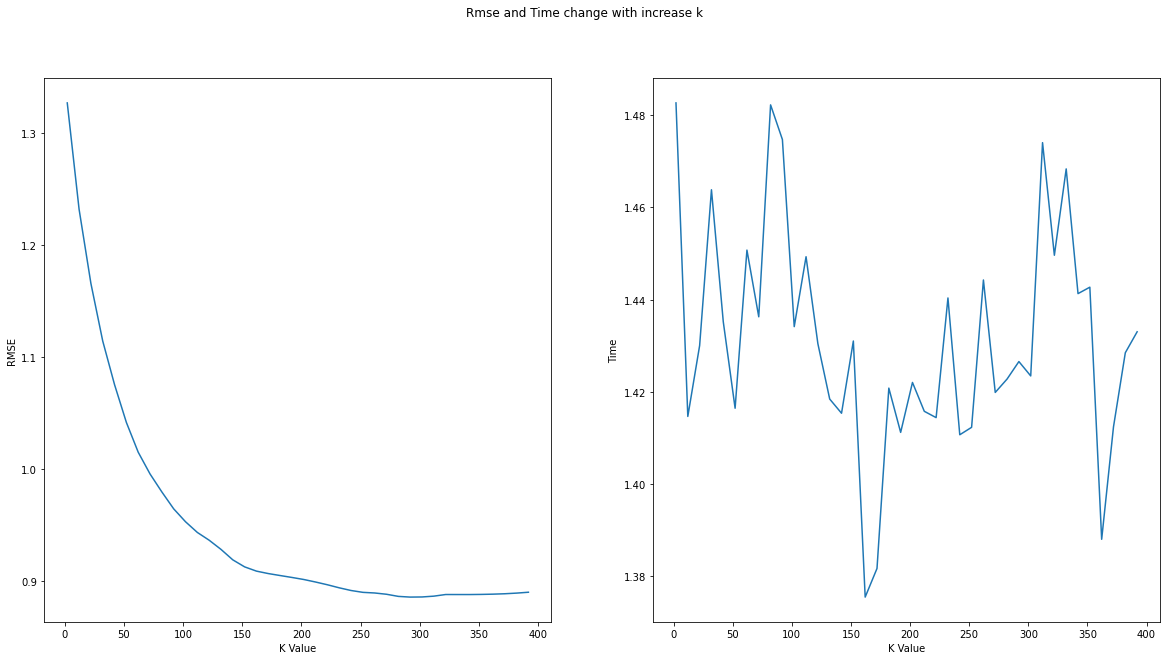

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Rmse and Time change with increase k')
ax1.plot(range(mink,topk,step),rmsek)
ax2.plot(range(mink,topk,step),timek)
ax1.set(xlabel='K Value', ylabel='RMSE')
ax2.set(xlabel='K Value', ylabel='Time')



There is really no significant difference between the cycles as it can be seen below. However, The mount of memory to keep this objects in memory increase with the size of k.

### Iterations
Below is a total of 10 random train test splits for the data with same value of k=100

There is really not a lot of differences on the final RMSE or time but there is a slighly edge over the UBCF described above

In [136]:
k=100
numbercycles=10
rmsec=np.zeros(numbercycles)
timec=np.zeros(numbercycles)
for i in range(numbercycles):
    test,train,xs,xts,ys,yts=getTestTrainSplit(utilityMatrix,200,100)
    start_time = time.time()
    rmsec[i]=getRmseIBCF(utilityMatrix,train,xs,xts,ys,yts,k)
    timec[i]=(time.time() - start_time)     

[Text(0.5, 0, 'Cycle'), Text(0, 0.5, 'Time')]

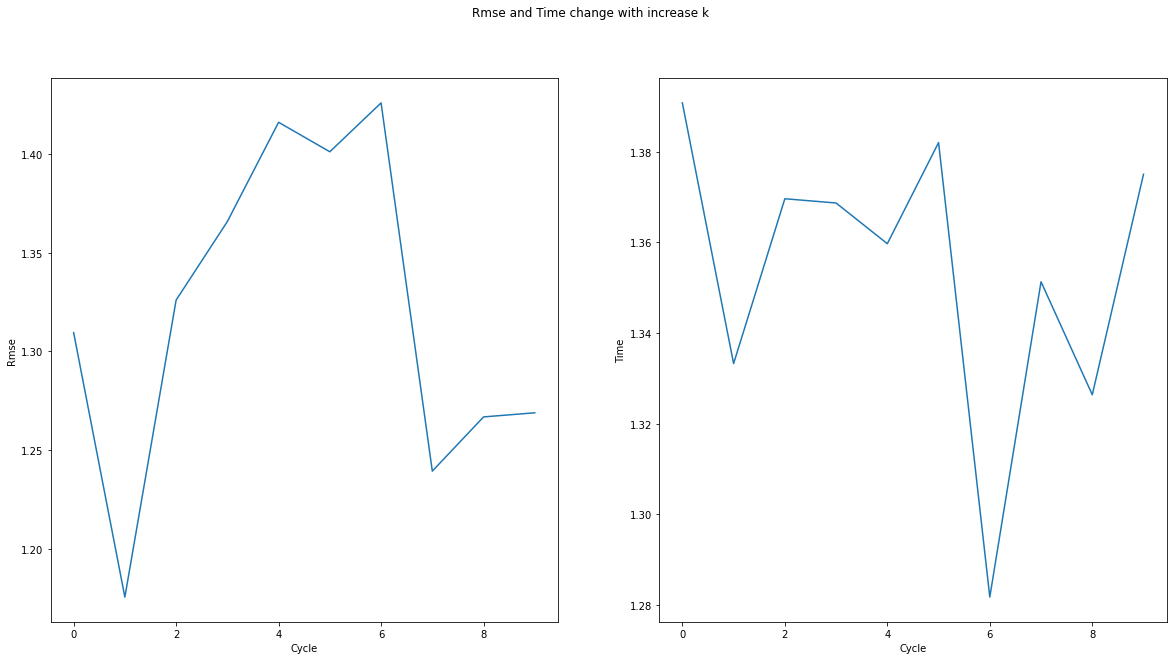

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Rmse and Time change with increase k')
ax1.plot(range(numbercycles),rmsec)
ax2.plot(range(numbercycles),timec)
ax1.set(xlabel='Cycle', ylabel='Rmse')
ax2.set(xlabel='Cycle', ylabel='Time')


### Predictions
The following are just functions required by the process.

In [138]:
def getUserQueryVector(userQuery,mapiddict,size):
    result=np.full(size,np.nan)
    for i in userQuery:
        result[mapiddict[i]]=userQuery[i]
    return result

def getMapIdDictCols(df):
    mapiddict={}
    j=0
    for i in df.columns:
        mapiddict[i]=j
        j+=1
    return mapiddict,df.shape[1]

def getMapIdDictRows(df):
    mapiddict={}
    j=0
    for i in df.index:
        mapiddict[i]=j
        j+=1
    return mapiddict,df.shape[0]


def getUserPredictions(utilityMatrix,queryVector,size,k,globalave):    
   
    print (queryVector.reshape(-1,1).shape)
    print (utilityMatrix.shape)

    if utilityMatrix.shape[1] == size+1:        
        utilityMatrix[size]=queryVector
    else:
        utilityMatrix=np.append(utilityMatrix,queryVector.reshape(-1,1),axis=1)
    print (utilityMatrix.shape)
    similarityMatrix=getSimilarityMatrix(pd.DataFrame(utilityMatrix))   
    print (similarityMatrix.shape)
    for i in range(len(queryVector)):        
        if np.isnan(queryVector[i]):
                r=getRatingIBCF(utilityMatrix,similarityMatrix,i,size+1,k,globalave,debug=False)
                queryVector[i]=r
    return queryVector


I simulate a input from the user and get a list of results

In [139]:
topn=10
k=30
userQuery={2571:5,
           541:5,
          1214:4,
          1200:4,      
          2999:1,
          3607:1,
          3233:1,
          3323:1   
          }
globalave=np.nanmean(ratings_movies)
mapiddict,size=getMapIdDictRows(ratings_movies)
queryVector=getUserQueryVector(userQuery,mapiddict,size)
queryVector=getUserPredictions(utilityMatrix,queryVector,size,k,globalave)
queryindex=np.argsort(queryVector)
topmovies=queryindex[-topn:]
movies.iloc[topmovies]

(3706, 1)
(3706, 6040)
(3706, 6041)
(3706, 3706)


,Movie,Title,Year,Filename
MovieID,,,,
3220,Night Tide (1961),Night Tide,1961,images/movies/3220.jpg
2984,On Any Sunday (1971),On Any Sunday,1971,images/movies/2984.jpg
1739,3 Ninjas: High Noon On Mega Mountain (1998),Ninjas High Noon On Mega Mountain,1998,images/movies/1739.jpg
3699,Starman (1984),Starman,1984,images/movies/3699.jpg
1350,"Omen, The (1976)",The Omen,1976,images/movies/1350.jpg
1047,"Long Kiss Goodnight, The (1996)",The Long Kiss Goodnight,1996,images/movies/1047.jpg
3321,"Waiting Game, The (2000)",The Waiting Game,2000,images/movies/3321.jpg
1007,"Apple Dumpling Gang, The (1975)",The Apple Dumpling Gang,1975,images/movies/1007.jpg
2443,Playing by Heart (1998),Playing by Heart,1998,images/movies/2443.jpg


In [140]:
topn=10
k=30
userQuery={1:5,3:1           
          }
globalave=np.nanmean(ratings_movies)
mapiddict,size=getMapIdDictRows(ratings_movies)
queryVector=getUserQueryVector(userQuery,mapiddict,size)
queryVector=getUserPredictions(utilityMatrix,queryVector,size,k,globalave)       
queryindex=np.argsort(queryVector)
topmovies=queryindex[-topn:]
movies.iloc[topmovies]

(3706, 1)
(3706, 6040)
(3706, 6041)
(3706, 3706)


,Movie,Title,Year,Filename
MovieID,,,,
2860,Blue Streak (1999),Blue Streak,1999,images/movies/2860.jpg
3220,Night Tide (1961),Night Tide,1961,images/movies/3220.jpg
2984,On Any Sunday (1971),On Any Sunday,1971,images/movies/2984.jpg
1739,3 Ninjas: High Noon On Mega Mountain (1998),Ninjas High Noon On Mega Mountain,1998,images/movies/1739.jpg
3699,Starman (1984),Starman,1984,images/movies/3699.jpg
1350,"Omen, The (1976)",The Omen,1976,images/movies/1350.jpg
3321,"Waiting Game, The (2000)",The Waiting Game,2000,images/movies/3321.jpg
1047,"Long Kiss Goodnight, The (1996)",The Long Kiss Goodnight,1996,images/movies/1047.jpg
1007,"Apple Dumpling Gang, The (1975)",The Apple Dumpling Gang,1975,images/movies/1007.jpg
